In [13]:
# ! pip install pyensembl
# ! pyensembl install --release 111 --species homo_sapiens
import os
import pandas as pd
from st_utils import get_gene_type
from constants import SAMPLES
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from st_utils import correct_tissue_names, name_parser
from constants import SAMPLES, matching_cores, CB_COLORS_5

import warnings
warnings.filterwarnings("ignore")

wd = os.getcwd()
print (f'working directory: {wd}')



working directory: /Users/whuan/dev/ist_benchmarking


In [14]:
from pyensembl.shell import collect_all_installed_ensembl_releases
print (collect_all_installed_ensembl_releases())

from pyensembl import EnsemblRelease
data = EnsemblRelease(release=111, species='homo_sapiens')



def get_transcript_length(gene, data):
    """
    from pyensembl import EnsemblRelease
    data = EnsemblRelease(release=104, species='homo_sapiens')
    """
    try:

        exonic_length_list = []
        gene_ids = data.gene_ids_of_gene_name(gene)
        if not gene_ids:
            # gene not found, return 'NA'
            return 'NA'
        
        # If a gene ID exists, use the first one
        gid = gene_ids[0]
        gene_obj = data.gene_by_id(gid)
        
        # Ensure we have transcripts
        if not gene_obj.transcripts:
            return 'NA'
        

        for transcript in gene_obj.transcripts:
            # Check that the transcript is protein-coding
            if transcript.biotype == "protein_coding":
                exonic_length = sum((exon.end - exon.start + 1) for exon in transcript.exons)
                exonic_length_list.append(exonic_length)
        
        return max(exonic_length_list)
    


    except Exception:
        # If anything goes wrong (e.g., an error looking up the gene),
        # return 'NA' to avoid crashing.
        return 'NA'

[EnsemblRelease(release=104, species='homo_sapiens'), EnsemblRelease(release=111, species='homo_sapiens')]


In [15]:

year = '2024'

samples = [x for x in SAMPLES]
if year == '2024':
    samples = [x for x in SAMPLES if '2024' in x]
elif year == '2023':
    samples = [x for x in SAMPLES if '2024' not in x]
else:
    samples = [x for x in SAMPLES]
print (samples)

convert_tma_name_dict = {'HTMA':'tTMA1','TUMOR2':'tTMA2', 'NORMAL':'nTMA', 'tTMA1':'tTMA1'}

by_sample = False

['2024_xenium_breast_htma', '2024_xenium_breast_tumor2', '2024_merscope_breast_htma', '2024_merscope_breast_tumor2', '2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2']


In [16]:
metric = f'count'
df_m = pd.DataFrame()
for sample in samples:
    print (f'sample: {sample}')
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample, df_t)
    # Reindex normal tissue cores 
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)
    # Consolidate tissue type
    # df_t = df_t.replace({'LN':'Lymph node','MARKER':'Marker'}) if 'htma' in sample else df_t
    df_t['sample'] = sample
    df_m = pd.concat([df_m,df_t])
    
df_m = df_m.loc[df_m['core'].isin(matching_cores)]
df_m['platform'] = df_m['sample'].apply(lambda x: name_parser(x)['platform'].upper())
df_m['panel'] = df_m['sample'].apply(lambda x: name_parser(x)['panel'])
df_m['tma'] = df_m['sample'].apply(lambda x: name_parser(x)['tma'].upper())

df_plot = df_m.copy()
df_plot = df_plot.drop(['sample'], axis=1)
df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']},{row['panel']}", axis=1)
df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()

if by_sample:
    df_plot = df_m.copy()
    df_plot = df_plot.groupby(['sample','gene']).agg({metric: 'sum'}).reset_index()
    df_plot = df_plot.pivot(index = 'gene', columns = 'sample', values = 'count').reset_index()

sample: 2024_xenium_breast_htma
sample: 2024_xenium_breast_tumor2
sample: 2024_merscope_breast_htma
sample: 2024_merscope_breast_tumor2
sample: 2024_cosmx_multitissue_htma
sample: 2024_cosmx_multitissue_tumor2


In [19]:

def gene_by_gene_plot(df_plot, platform_panel_1, platform_panel_2, tmas, year, fontsize=20, marker_size=5):
    
    marker_color = 'blue'
    # Focus on relevant columns
    df_pair = df_plot[['gene', platform_panel_1, platform_panel_2, 'transcript_length']].copy()
    df_pair = df_pair.reset_index(drop=True).dropna()
    df_pair['gene_type'] = df_pair['gene'].apply(lambda x:get_gene_type(x))
    df_pair = df_pair.loc[df_pair['gene_type']=='gene']

    # Create a 'fold' column
    df_pair['fold'] = df_pair.apply(lambda row: row[platform_panel_1] / row[platform_panel_2], axis=1)

    # Bin the transcript_length into 3 categories
    df_pair['transcript_length_bin'] = pd.cut(
        df_pair['transcript_length'],
        bins=[0, 2000, 5000, float('inf')],
        labels=['<2000', '2000-5000', '>5000']
    )


    x = df_pair[platform_panel_1]
    y = df_pair[platform_panel_2]

    r, p = sp.stats.spearmanr(
    np.log10(x.replace(0, np.nan)).dropna(),
    np.log10(y.replace(0, np.nan)).dropna(),
    )

    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"
    m_fold = round(df_pair['fold'].median(), 2)

    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)


    # Define custom colors for specific bins
    color_mapping = {
        '<2000': CB_COLORS_5['blue_dark'],
        '2000-5000': CB_COLORS_5['green'],
        '>5000': CB_COLORS_5['red']
    }

    # Scatter plot
    plt.figure(figsize=(6, 6))

    # Loop through the data to assign colors based on transcript_length_bin
    for xi, yi, bin_value in zip(x, y, df_pair['transcript_length_bin']):
        marker_color = color_mapping[bin_value]
        plt.loglog(
            xi,
            yi,
            linestyle='none',  # Ensure no connecting line between points
            marker='o',
            markersize=6,
            markerfacecolor='none',
            markeredgewidth=1,
            markeredgecolor=marker_color,
        )

    # Fitting the line in log-log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    coefficients = np.polyfit(log_x, log_y, 1)
    
    polynomial = np.poly1d(coefficients)
    x_poly = np.logspace(np.log10(min(x)), np.log10(max(x)), 100)
    log_y_poly = polynomial(np.log10(x_poly))
    y_poly = 10 ** log_y_poly

    # Calculate residuals and standard error
    log_y_fitted = polynomial(log_x)
    residuals = log_y - log_y_fitted
    std_err = np.sqrt(np.sum(residuals**2) / (len(log_y) - 2))
    residuals_poly = [10 ** abs(x) for x in residuals]
    y_fitted = 10 ** log_y_fitted
    residuals_poly = y - y_fitted
    std_err_linear = np.sqrt(np.sum(residuals_poly**2) / (len(y) - 2))

    # Compute the 95% confidence interval in linear space
    t_value = 1.96  # For 95% confidence interval
    y_upper = y_poly + t_value * std_err_linear
    y_lower = y_poly - t_value * std_err_linear


    # Plot the fitted line
    plt.plot(x_poly, y_poly, label='Fitted Line', color='red')

    # Plot the confidence interval
    plt.fill_between(x_poly, y_lower, y_upper, color='#D3D3D3', alpha=0.1, label='95% CI')

    # Reference line y=x
    min_all = np.min([x.min(), y.min()])
    max_all = np.max([x.max(), y.max()])
    xy_line_lim = [min_all, max_all]
    plt.plot(xy_line_lim, xy_line_lim, color='#D3D3D3', linestyle='-.', alpha=0.75)

    annotation_text = f"Spearman R = {round(r,2)}\np value {p_text}\nMedian fold = {m_fold}"
    
    plt.text(min_all*1.01, max_all*1.2, annotation_text, fontsize=fontsize-2, verticalalignment='top')     

    if tmas == ['tTMA1']:
        plt.xlabel(f"Gene expression of\n{platform_panel_1}", fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2}", fontsize=fontsize)
    else:
        plt.xlabel(f"Gene expression of\n{platform_panel_1} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})",
                   fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})",
                   fontsize=fontsize)

    # Label axes
    if tmas == ['tTMA1']:
        plt.xlabel(f"Gene expression of\n{platform_panel_1}", fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2}", fontsize=fontsize)
    else:
        plt.xlabel(f"Gene expression of\n{platform_panel_1} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})",
                   fontsize=fontsize)
        plt.ylabel(f"Gene expression of\n{platform_panel_2} from {convert_tma_name_dict[tmas[0]]}({year[-2:]})",
                   fontsize=fontsize)


    # Custom legend for markers
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='<2000',
            markerfacecolor='none', markeredgecolor=CB_COLORS_5['blue_dark'], markersize=6, markeredgewidth=1),
        Line2D([0], [0], marker='o', color='none', label='2000-5000',
            markerfacecolor='none', markeredgecolor=CB_COLORS_5['green'], markersize=6, markeredgewidth=1),
        Line2D([0], [0], marker='o', color='none', label='>5000',
            markerfacecolor='none', markeredgecolor=CB_COLORS_5['red'], markersize=6, markeredgewidth=1),
    ]

    plt.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        frameon=False,
        fontsize=fontsize-6,
        title='Transcript length'
    )

    # Save and show the plot
    plt.savefig(f"{wd}/figures/gene_length/{year}_{'_and_'.join(tmas)}_{platform_panel_1}_vs_{platform_panel_2}.png",
                bbox_inches='tight', transparent=True)
    # plt.savefig(f"{wd}/figures/gene_length/{year}_{'_and_'.join(tmas)}_{platform_panel_1}_vs_{platform_panel_2}.eps",
    #             bbox_inches='tight', transparent=True)
    plt.show()

Xenium,Breast panel CosMx,1k panel ['HTMA']


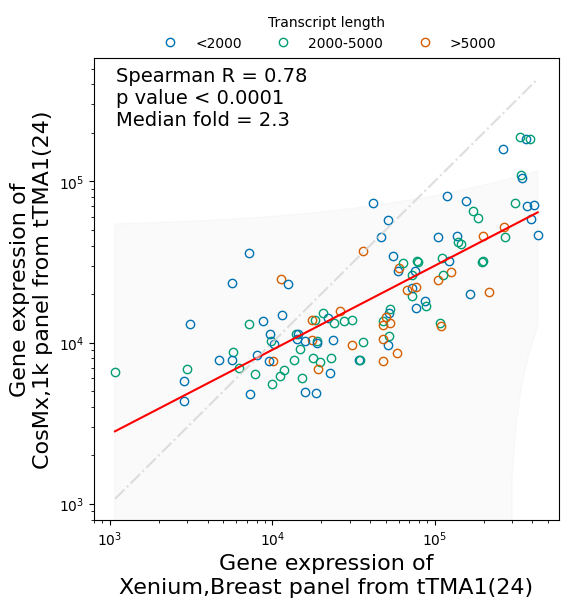

CosMx,1k panel MERSCOPE,Breast panel ['HTMA']


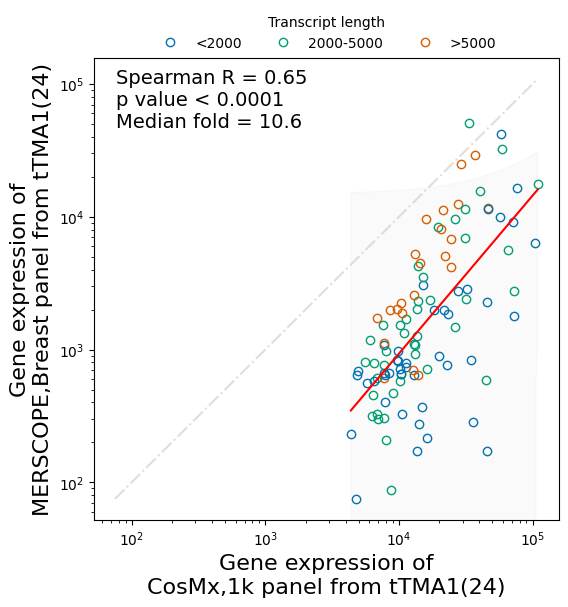

Xenium,Breast panel MERSCOPE,Breast panel ['HTMA']


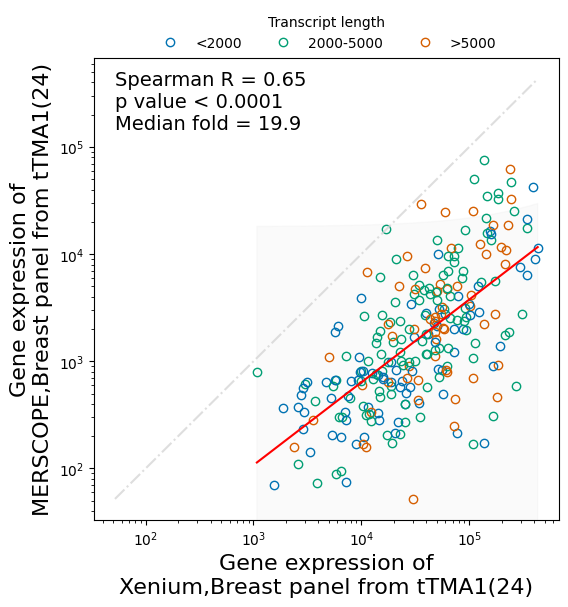

Xenium,Breast panel CosMx,1k panel ['TUMOR2']


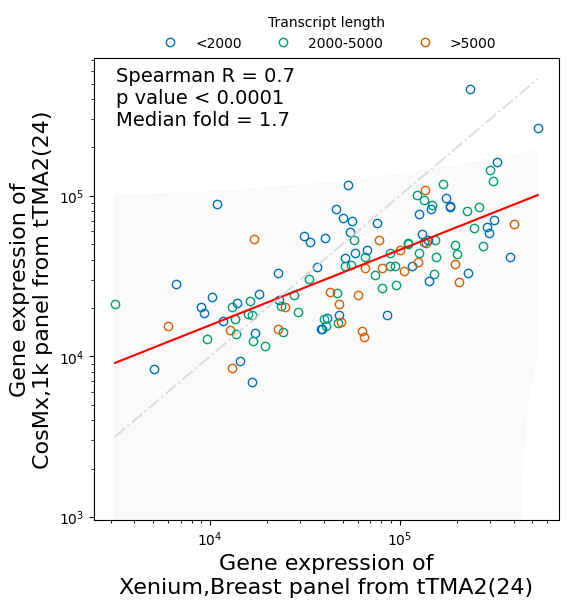

CosMx,1k panel MERSCOPE,Breast panel ['TUMOR2']


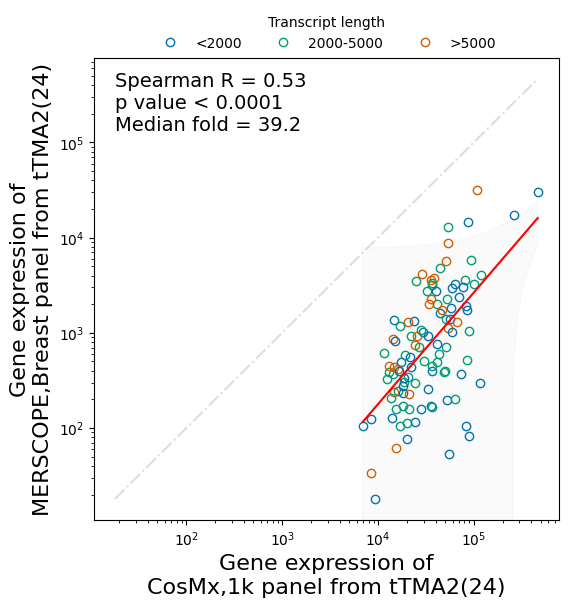

Xenium,Breast panel MERSCOPE,Breast panel ['TUMOR2']


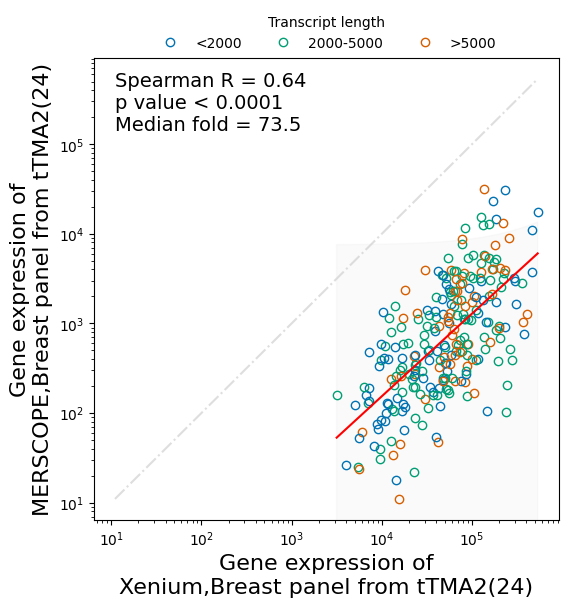

In [20]:
if not os.path.exists(f'{wd}/figures/Fig_2_Technical_Performance'):
    os.makedirs(f'{wd}/figures/Fig_2_Technical_Performance')

linear_p_value_threshold = 0.05
fontsize=16

if year =='2023':

    for tmas in [['HTMA'], ['NORMAL']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k panel',
                    'MERSCOPE,Breast panel', 
                    'MERSCOPE,Lung panel',
                    'Xenium,Breast panel',
                    'Xenium,Lung panel',
                    'Xenium,Multi-tissue panel']
        

        df_plot['transcript_length'] = df_plot['gene'].apply(lambda x: get_transcript_length(x, data))
        df_plot = df_plot.loc[df_plot['transcript_length'] != 'NA']
        df_plot['transcript_length'] = df_plot['transcript_length'].astype('int')

        for count, platform_panel_pair in enumerate(
            [('Xenium,Breast panel','CosMx,1k panel'),
            ('Xenium,Lung panel','CosMx,1k panel'),
            ('MERSCOPE,Breast panel','CosMx,1k panel',),
            ('MERSCOPE,Lung panel','CosMx,1k panel'),
            ('Xenium,Breast panel','MERSCOPE,Breast panel'),
            ('Xenium,Lung panel','MERSCOPE,Lung panel'),
            ('Xenium,Multi-tissue panel','CosMx,1k panel')
                                    ]):
            color_index = int(np.floor(count/2+1))

            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)

            gene_by_gene_plot(
                df_plot,
                platform_panel_1,
                platform_panel_2,
                tmas,
                year,
                fontsize=fontsize,
                marker_size=5,

            )

elif year =='2024':

    for tmas in [['HTMA'], ['TUMOR2']]:
        df_plot = df_m.loc[df_m['tma'].isin(tmas)]
        df_plot = df_plot.drop(['sample'], axis=1)
        df_plot = df_plot.groupby(['platform','panel','gene']).agg({metric: 'sum'}).reset_index()
        df_plot['platform_panel'] = df_plot.apply(lambda row: f"{row['platform']}_{row['panel']}", axis=1)
        df_plot = df_plot.pivot(index = 'gene', columns = 'platform_panel', values = 'count').reset_index()
        df_plot.columns = ['gene',
                    'CosMx,1k panel',
                    'MERSCOPE,Breast panel', 
                    'Xenium,Breast panel']
        
        df_plot['transcript_length'] = df_plot['gene'].apply(lambda x: get_transcript_length(x, data))
        df_plot = df_plot.loc[df_plot['transcript_length'] != 'NA']
        df_plot['transcript_length'] = df_plot['transcript_length'].astype('int')

        for count, platform_panel_pair in enumerate([
            ('Xenium,Breast panel','CosMx,1k panel'),
            ('CosMx,1k panel','MERSCOPE,Breast panel'),
            ('Xenium,Breast panel','MERSCOPE,Breast panel'),
            ]):

            color_index = count + 1
            
            platform_panel_1 = platform_panel_pair[0]
            platform_panel_2 = platform_panel_pair[1]

            print(platform_panel_1, platform_panel_2, tmas)
            
            gene_by_gene_plot(
                df_plot,
                platform_panel_1,
                platform_panel_2,
                tmas,
                year,
                fontsize=fontsize,
                marker_size=5,

            )